In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///resources_hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)
inspector = inspect(engine)

In [10]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.id, 
       Measurement.station,
       Measurement.date,
       Measurement.prcp,
       Measurement.tobs
       ]
precipitation_db = pd.DataFrame(session.query(*sel).all())
precipitation_db = precipitation_db.replace(np.nan, 0)


precipitation_db.tail()

,id,station,date,prcp,tobs
19545,19546,USC00516128,2017-08-19,0.09,71.0
19546,19547,USC00516128,2017-08-20,0.00,78.0
19547,19548,USC00516128,2017-08-21,0.56,76.0
19548,19549,USC00516128,2017-08-22,0.50,76.0
19549,19550,USC00516128,2017-08-23,0.45,76.0


# Exploratory Climate Analysis

How many months of history you need?  12


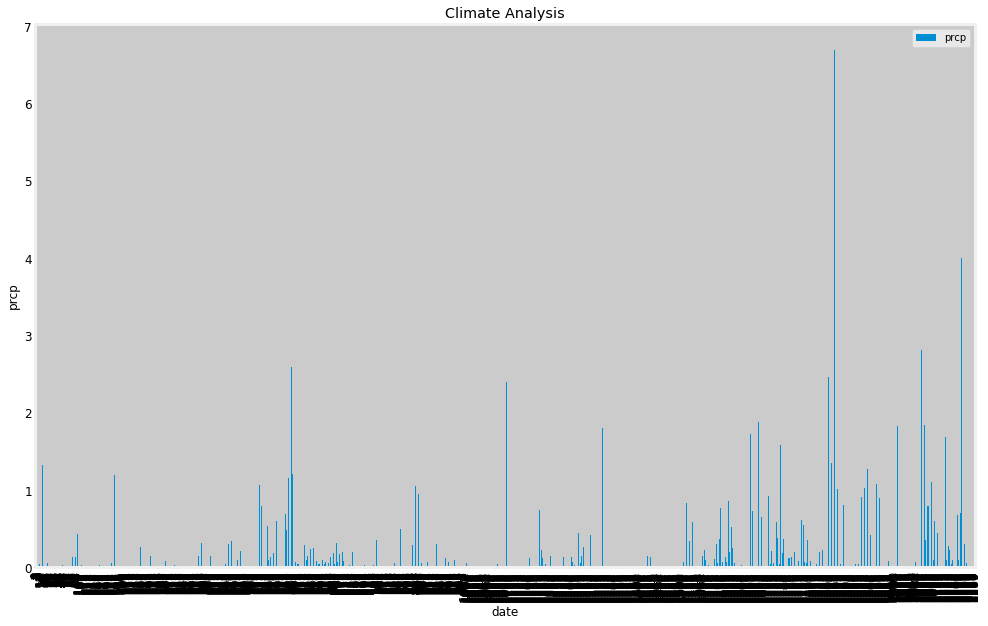

In [26]:
# Calculate the date 1 year ago from the last data point in the database
last_date = precipitation_db['date'].iloc[-1]
last_date = datetime.strptime(last_date, "%Y-%m-%d")
n = int(input("How many months of history you need?  "))
from_date = last_date - timedelta(days = (n * 30))

# Design a query to retrieve the last 12 months of precipitation data and Save the query results as a Pandas DataFrame
sel = [Measurement.station,
       Measurement.date, 
       Measurement.prcp,
       Measurement.tobs
       ]

last_year_precipitation = pd.DataFrame(session.query(*sel).\
    filter(func.strftime( Measurement.date) >= from_date).all())
last_year_precipitation = last_year_precipitation.replace(np.nan, 0)

# Sort the dataframe by date
last_year_precipitation.sort_values(by='date', ascending = True)

# Use Pandas Plotting with Matplotlib to plot the data and set the index to the date column
#last_year_precipitation.set_index('date', inplace=True)
#last_year_precipitation.plot.bar(figsize =  (20,10))
bar_plot = last_year_precipitation[['date','prcp']].plot(kind='bar', title ="Climate Analysis", figsize=(15, 10),\
                                                   legend=True, fontsize=12)
bar_plot.set_xlabel("date", fontsize=12)
bar_plot.set_ylabel("prcp", fontsize=12)
plt.show()
plt.show()




In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_db.describe()

,id,prcp,tobs
count,19550.000000,19550.000000,19550.000000
mean,9775.500000,0.148753,73.097954
std,5643.743217,0.453021,4.523527
min,1.000000,0.000000,53.000000
25%,4888.250000,0.000000,70.000000
50%,9775.500000,0.010000,73.000000
75%,14662.750000,0.090000,76.000000
max,19550.000000,11.530000,87.000000



# Climate App

In [15]:
# Design a query to show how many stations are available in this dataset?
sel = [Measurement.id, 
       Measurement.station,
       Measurement.date,
       Measurement.prcp,
       Measurement.tobs
       ]
stations = session.query(*sel).group_by(Measurement.station).all()
print(len(stations))

9


In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                                  group_by(Measurement.station).all()
active_stations_db = pd.DataFrame(active_stations, columns=['Station', 'Count'])
active_stations_db = active_stations_db.sort_values(by='Count', ascending = False)
active_stations_db = active_stations_db.reset_index(drop=True)
active_stations_db
# List the stations and the counts in descending order.


,Station,Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active = str(active_stations_db['Station'].iloc[0])
most_active

sel = [ 
       Measurement.station,
       Measurement.tobs
       ]
most_active_db = pd.DataFrame(session.query(*sel).filter(Measurement.station.like(most_active)).all())
most_active_db.describe()


,tobs
count,2772.000000
mean,71.663781
std,4.357642
min,54.000000
25%,69.000000
50%,72.000000
75%,74.000000
max,85.000000


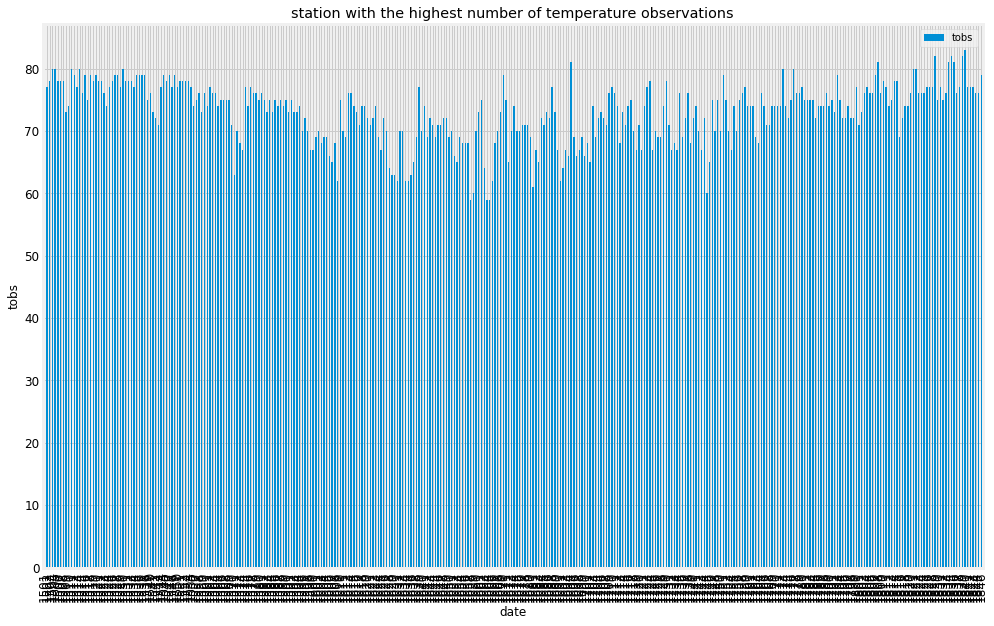

In [27]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_stations = session.query(Measurement.station, func.count(Measurement.tobs)).\
                                  group_by(Measurement.station).all()
temp_active_db = pd.DataFrame(active_stations, columns=['Station', 'Count'])
temp_active_db = temp_active_db.sort_values(by='Count', ascending = False)
temp_active_db = active_stations_db.reset_index(drop=True)
temp_active_station = str(active_stations_db['Station'].iloc[0])
temp_active_station_db = last_year_precipitation[last_year_precipitation['station'] == temp_active_station]
temp_active_station_db
bar_plot_temp = temp_active_station_db[['date','tobs']].plot(kind='bar', title ="station with the highest number of temperature observations",\
                                                             figsize=(15, 10),legend=True, fontsize=12)
bar_plot_temp.set_xlabel("date", fontsize=12)
bar_plot_temp.set_ylabel("tobs", fontsize=12)
plt.show()


![precipitation](Images/station-histogram.png)

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
